# Line Fits with MCMC Errors

## Authors
B.W. Holwerda 

## Learning Goals
* Linear fits can be done in more than one way
* Use chisq to compare the quality of fits.
* Use Bootstrapping to explore the uncertainty.
* Use MCMC burn to estimate the uncertainty
* See what happens when the "Nuisance parameter" is not Gaussian.

## Keywords
Gaussian, MCMC, Bootstrap, Chi-squared, linear fits

## Companion Content

emcee and corner modules need to be installed for this project.

## Summary

See also:
https://emcee.readthedocs.io/en/stable/tutorials/line/

<hr>


## Student Name and ID:



## Date:

<hr>

# How to fit a straight line through points

This is the simpelest and least complicated thing to do in science. There is a (suspected/predicted) linear relationship. There is data, with uncertainties. Fit a line.

First wil will set up the artificial data and the true values of the relationship. 

Then, the y-data is messed up by a certain fraction that is *underestimated by our error*. This is not the exeption in experimental data, this is closer to the rule!   


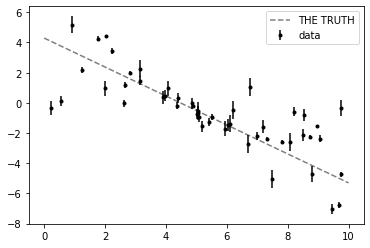

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Choose the "true" parameters.
m_true = -0.9594 # slope
b_true = 4.294   # intercept
f_true = 0.534   # underestimate fraction of uncertainties (crud factor)

x_true = np.linspace(0,10,100)
y_true = m_true*x_true+b_true

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
# for Exercise 7 -- comment out the above line and uncomment the below and rerun everything.
# y += np.abs(f_true*y) * np.random.exponential(scale=0.3,size=N) # a 

y += yerr * np.random.randn(N)

plt.errorbar(x,y,yerr,fmt='k.',label='data')
plt.plot(x_true,y_true,'k--',alpha=0.5,label='THE TRUTH')
plt.legend()
plt.show()

## polyfit

Fit a polynomial to the data (easy!) 

$$ p(x) = p[0] * x^{deg} + ... + p[deg] $$

of degree deg to points (x, y). Returns a vector of coefficients p that minimises the squared error in the order deg, deg-1, … 0.

Benefit is that one can up the complexity by simply changing the degree of the polynomial.

### Exercise 1 - Fit a 2-degree polynomial 

use np.polyfit to fit to the x and y (include yerr weighting) and plot the fit using np.poly1d. 

In [4]:
# fit 1 polyfit


### Exercise 2 - Compute the $\chi^2$ for this fit.

Compute the value of $\chi^2$ and save in a parameter.

In [5]:
# student work here

### Exercise 3 - Compare the mean error to the scatter

Compare the mean error (plot a horizontal bar of that length) to a histogram of the residual (the data - model).

In [6]:
# student work here


### Exercise 4 - How do they compare?

How does the residual and the error in the data compare? Does the residual ook Gaussian(ish)? Is the width of the distribution similar to that of the mean error?

*your answer here*

## Linear Least Square Fit

But we don't need to mess with polynomials! This is a linear fit after all. And numpy linalg.solve can do that for us. 

In [7]:
# Fit 1 Linear Least Squares
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

x_ls = np.linspace(0,10,100)
y_ls = m_ls*x_ls + b_ls

# plot this over the data
# student work here



### Exercise 5 - Compute the $\chi^2$ for the least square fit

Compute the value of $\chi^2$ and save in a parameter.

In [8]:
# student work here


## Maximum Likelihood Fit

What we can do is fit a function to this minimizing the likelyhood. 

In [9]:
# Fit no 2 - Maximum likelihood estimation¶
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2*np.exp(2*log_f)
    return -0.5*np.sum((y-model)**2/sigma2 + np.log(sigma2))


In [10]:
from scipy.optimize import minimize
np.random.seed(42)

nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1*np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

x_ml = np.linspace(0,10,100)
y_ml = m_ml*x_ml + b_ml


### Exercise 6 - Plot all the fits

Plot all three fits. 

In [11]:
# student work


### Exercise 7 - Calculate $\chi^2$ for all three methods.

Look up what the definition of $\chi^2$ is and calculate it for all three fits.

In [12]:
# student work


This still better $\chi^2$ than the polyfit or the linear fit!
But still not a great $\chi^2$ value or reduced $\chi^2$ (divided by 2).

Because the data is skewed *on top of having a Gaussian uncertainty*. What happens if we remove that (well behaved data i.e. comment out code line 17)?

But how much closer are we to THE TRUE RELATION? Much better. 
The remaining issue is that now we do not have a good uncertainty estimate. 


### Exercise 8 - What happens to the $\chi^2$ values if we remove the additional uncertainty?

Comment out line 17 and see what happens to the $\chi^2$ you calculated

*your answer here*

### Exercise 9 - Jacknifing

uncomment line 17 and let's try jacknifing.

We can use the maximum likelyhood fits but on subsamples. Loop N times (size of the sample), dropping a single value (not a big sample after all) and calculate the mean and standard deviation of the likelyhood fits.

Tip: generage a range of values that are the *indices* for x,y and then scramble those. 

In [13]:
# student work


### Exercise 10 - Bootstrapping

We can loop throught subsamples in our sample and redo the maximum likelyhoods. Run through a dozen subsamples and fit again with maximum likelihood method to a randomly chosen sample with replacement. Calculate the mean and standard deviation of N fits, where N is the size of the sample.  

In [14]:
# student work here
# Bootstrapping



In [15]:
print(m_true,b_true,np.log(f_true))


-0.9594 4.294 -0.6273594400219421


### Exercise 11 - Note any differences between Jacknife and Bootstrap. 

Try running your bootstrap and jacknife procedures on the neat Gaussian data (line 17 commented out) and the one with a nuisance parameter (keep line 17). What do you notice?

*student work here*

## Monte-Carlo Markov-Chain

Now we run through a run of the Monte-Carlo Markov Chains. You will need the emcee module in python installed.
This is a way to estimate the uncertainties after a maximum likelyhood fit. That gave us optimal values. Bootstrapping is one way but only if the additional uncertainty is Gaussian. What if it isn't? 

There is often the possibility of a "nuisance parameter" for which one would like a distribution function. See for details here: https://emcee.readthedocs.io/en/stable/tutorials/line/

For this part you need to have emcee installed. 

In [16]:
import emcee
print(emcee.__version__)

def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

3.0.2


We will now run all the samplers. We start the walkers in a tiny Gaussian ball around the maximum likelihood result and then run 5,000 steps of MCMC.

In [17]:
pos = soln.x + 1e-4*np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:05<00:00, 858.90it/s]


## Plot the evolution of all the walkers in the three parameters space.

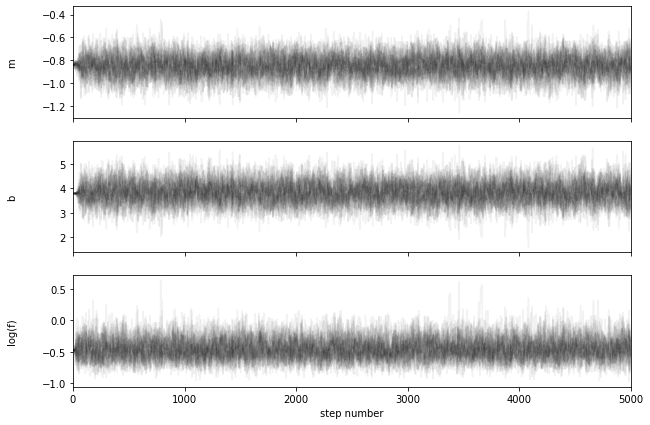

In [18]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.05)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [19]:
tau = sampler.get_autocorr_time()
print(tau)

[36.68473172 37.66050322 35.95257368]


In [20]:
flat_samples = sampler.get_chain(flat=True)

print(flat_samples.shape)

(160000, 3)


## Plot the distributions of the sampler chains.

We use the corner utility to map out the sampler chains and plot the true values. 

In [2]:
import corner
fig = corner.corner(flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]);

NameError: name 'flat_samples' is not defined

### Exercise 12 - Plot the Maximum Likelyhood Values

Plot the maximum likelyhood values found earlier.

In [16]:
# student work here


In [111]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [17]:
# plot the possible fits
x0 = np.linspace(0, 10, 500)
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "g", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true*x0+b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

print(np.mean)

NameError: name 'flat_samples' is not defined

In [18]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

NameError: name 'ndim' is not defined

### Exercise 13 - Comparison

Compare the uncertainty of the MCMC, Jacknife and Bootstrap techniques. With line 17 commented out and with it included. 
Comment on the diffrences in the results. Discuss the errorbars. 

*your answer here*

### Exercise 14 - Extra Non-Gaussian "Nuisance Parameter"

Comment out line 17 and uncomment line 19. This makes the Y-values non-Gaussian but skewed exponentially. What happens to all the fits?

*your answer here*